In [343]:
# Depression Severity Prediction using Deep Learning Techniques

In [344]:
# This is the step 1, in which I have synthetically generated the dataset using python

In [345]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [346]:
# ============================================================
# ✅ 1. Generate synthetic PPG-like signals for each emotion
# ============================================================
def generate_ppg(emotion, length=4050, fs=45):
    """
    Generates a synthetic 1D PPG-like signal for a given emotion.
    """

    t = np.linspace(0, 90, length)  # 90 seconds total

    # Base heartbeat-like waveform
    base = np.sin(2 * np.pi * 1.2 * t) + 0.25 * np.sin(2 * np.pi * 3.6 * t)
    noise = np.random.normal(0, 0.05, length)

    if emotion == 'calm':
        signal = base + noise

    elif emotion == 'happiness':
        signal = 1.1 * base + np.random.normal(0, 0.07, length)

    elif emotion == 'sadness':
        signal = 0.8 * base + np.random.normal(0, 0.05, length)

    elif emotion == 'tension':
        signal = 0.9 * base + np.random.normal(0, 0.08, length)

    elif emotion == 'fear':
        signal = 1.2 * base + np.random.normal(0, 0.10, length)

    else:
        signal = base + noise  # fallback

    # Normalize between -1 and 1
    signal = signal / np.max(np.abs(signal))
    return signal


In [347]:
# ============================================================
# ✅ 2. Stress Score Mapping (Base Mean Values)
# ============================================================
# These mean values match the research paper
emotion_to_mean_score = {
    'calm': 10,
    'happiness': 15,
    'sadness': 20,
    'tension': 25,
    'fear': 30
}


In [348]:
# Add Gaussian variation to simulate real physiological data
# Step 1: wider stress variation (for realistic diversity)
def get_stress_score(emotion):
    base = emotion_to_mean_score[emotion]
    return float(np.random.normal(base, 5.0))  # ±5

# Step 2: robust stratified split
mean_stress['stress_level'] = pd.qcut(mean_stress['stress_score'], q=2, labels=['low', 'high'])


# ============================================================
# ✅ 3. Output folders
# ============================================================
os.makedirs("data", exist_ok=True)
os.makedirs("metadata", exist_ok=True)


In [349]:
# ============================================================
# ✅ 4. Create dataset
# ============================================================
num_subjects = 50
emotions = list(emotion_to_mean_score.keys())
records = []

for sid in range(1, num_subjects + 1):

    gender = np.random.choice(['Male', 'Female'])
    age = np.random.randint(18, 25)

    for emotion in emotions:

        # Generate signal
        signal = generate_ppg(emotion)

        # Save as .npy
        file_name = f"S{sid:03d}_{emotion}.npy"
        file_path = os.path.join("data", file_name)
        np.save(file_path, signal)

        # Create floating stress score
        stress_score = get_stress_score(emotion)

        # Save metadata row
        records.append([
            f"S{sid:03d}", emotion, file_path, 45, 90.0, len(signal),
            stress_score, gender, age,
            datetime.now().strftime('%Y-%m-%d')
        ])

columns = [
    'subject_id', 'emotion', 'signal_file', 'sampling_rate',
    'duration_sec', 'signal_length', 'stress_score', 'gender',
    'age', 'record_date'
]

metadata_df = pd.DataFrame(records, columns=columns)
metadata_df.to_csv('metadata/stress_dataset_metadata.csv', index=False)

print("✅ Synthetic dataset successfully created!")
print(metadata_df.head())

✅ Synthetic dataset successfully created!
  subject_id    emotion              signal_file  sampling_rate  duration_sec  \
0       S001       calm       data/S001_calm.npy             45          90.0   
1       S001  happiness  data/S001_happiness.npy             45          90.0   
2       S001    sadness    data/S001_sadness.npy             45          90.0   
3       S001    tension    data/S001_tension.npy             45          90.0   
4       S001       fear       data/S001_fear.npy             45          90.0   

   signal_length  stress_score  gender  age record_date  
0           4050      8.275506  Female   24  2025-11-12  
1           4050     19.330332  Female   24  2025-11-12  
2           4050     17.778289  Female   24  2025-11-12  
3           4050     20.469921  Female   24  2025-11-12  
4           4050     27.854377  Female   24  2025-11-12  


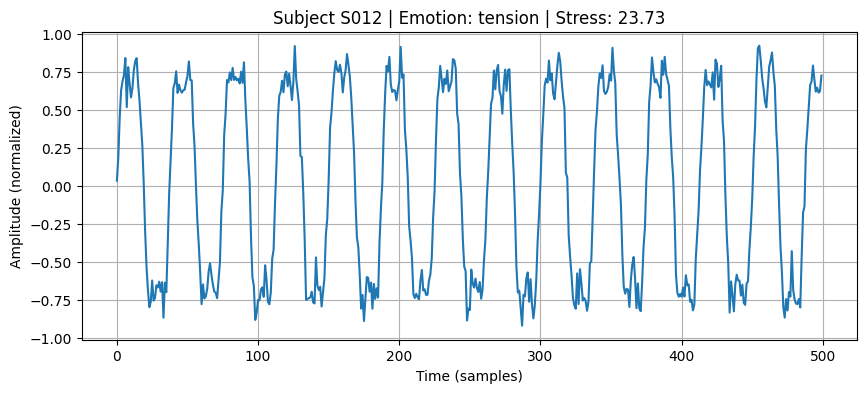

In [350]:
# ============================================================
# ✅ 5. Quick visualization check
# ============================================================
meta = pd.read_csv('metadata/stress_dataset_metadata.csv')

sample = meta.sample(1).iloc[0]
signal = np.load(sample.signal_file)

plt.figure(figsize=(10,4))
plt.plot(signal[:500])
plt.title(f"Subject {sample.subject_id} | Emotion: {sample.emotion} | Stress: {sample.stress_score:.2f}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (normalized)")
plt.grid(True)
plt.show()



In [351]:
print("\nEmotion counts:\n", meta['emotion'].value_counts())
print("\nMean Stress per Emotion:\n", meta.groupby('emotion')['stress_score'].mean())



Emotion counts:
 emotion
calm         50
happiness    50
sadness      50
tension      50
fear         50
Name: count, dtype: int64

Mean Stress per Emotion:
 emotion
calm          9.320533
fear         29.341489
happiness    14.801943
sadness      20.570355
tension      24.732391
Name: stress_score, dtype: float64


In [352]:
# Now comes step 2 of my project : Preprocessing

# In this we’ll handle three major preprocessing tasks that correspond exactly to what the paper did:

# Wavelet denoising → remove noise and artifacts from the raw PPG

# PRV extraction → compute Pulse Rate Variability (time difference between peaks)

# dPPG segmentation → extract discrete pulse waveforms (using valleys as segment markers)

In [353]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt  # for wavelet transforms
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


In [354]:
def wavelet_denoise(signal, wavelet='db8', level=3):
    """
    Denoises a 1D signal using wavelet thresholding.
    Arguments:
        signal : np.ndarray : input raw signal
        wavelet : str : wavelet type (Daubechies recommended)
        level : int : decomposition level
    Returns:
        np.ndarray : denoised signal
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))

    coeffs[1:] = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    denoised_signal = pywt.waverec(coeffs, wavelet)

    return denoised_signal[:len(signal)]


In [355]:
def extract_prv(signal, fs=45):
    """
    Extract Pulse Rate Variability (PRV) from a PPG signal.
    PRV = time difference between consecutive pulse peaks.
    """
    # Detect main peaks
    peaks, _ = find_peaks(signal, distance=fs*0.5)  # minimum 0.5s apart

    # Convert peak indices to time (seconds)
    times = peaks / fs

    # Compute time difference between peaks
    prv = np.diff(times)

    return prv, peaks


In [356]:
def extract_dppg(signal, fs=45, interp_len=100):
    """
    Extract discrete pulse waves (dPPG) using valley detection.
    Each dPPG represents one heartbeat waveform.
    """
    # Detect valleys (inverted peaks)
    valleys, _ = find_peaks(-signal, distance=fs*0.5)

    dppg_segments = []

    for i in range(len(valleys) - 1):
        start = valleys[i]
        end = valleys[i + 1]
        seg = signal[start:end]

        # Skip too short or too long segments
        if len(seg) < 10:
            continue

        # Normalize length by interpolation
        x_old = np.linspace(0, 1, len(seg))
        x_new = np.linspace(0, 1, interp_len)
        f = interp1d(x_old, seg)
        seg_interp = f(x_new)

        dppg_segments.append(seg_interp)

    return np.array(dppg_segments), valleys


In [357]:
# Load metadata
meta = pd.read_csv('metadata/stress_dataset_metadata.csv')

# Create output folders
os.makedirs('processed/prv', exist_ok=True)
os.makedirs('processed/dppg', exist_ok=True)

processed_records = []

for idx, row in meta.iterrows():
    sid = row['subject_id']
    emotion = row['emotion']
    signal_path = row['signal_file']
    stress_score = row['stress_score']

    # Load raw signal
    raw_signal = np.load(signal_path)

    # Step 1: Denoise
    denoised = wavelet_denoise(raw_signal)

    # Step 2: Extract PRV
    prv, peaks = extract_prv(denoised)
    prv_path = f'processed/prv/{sid}_{emotion}_prv.npy'
    np.save(prv_path, prv)

    # Step 3: Extract dPPG
    dppg, valleys = extract_dppg(denoised)
    dppg_path = f'processed/dppg/{sid}_{emotion}_dppg.npy'
    np.save(dppg_path, dppg)

    processed_records.append([sid, emotion, prv_path, dppg_path, stress_score])

print("✅ Preprocessing complete for all signals.")


✅ Preprocessing complete for all signals.


In [358]:
columns = ['subject_id', 'emotion', 'prv_file', 'dppg_file', 'stress_score']
processed_df = pd.DataFrame(processed_records, columns=columns)
processed_df.to_csv('metadata/processed_dataset_metadata.csv', index=False)
print("✅ Processed metadata saved at metadata/processed_dataset_metadata.csv")


✅ Processed metadata saved at metadata/processed_dataset_metadata.csv


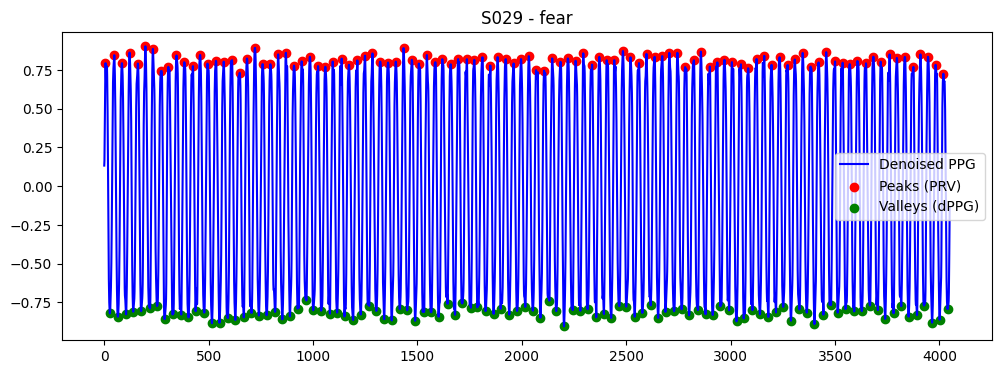

In [359]:
sample = meta.sample(1).iloc[0]
signal = np.load(sample.signal_file)
denoised = wavelet_denoise(signal)
_, peaks = extract_prv(denoised)
_, valleys = extract_dppg(denoised)

plt.figure(figsize=(12,4))
plt.plot(denoised, label='Denoised PPG', color='blue')
plt.scatter(peaks, denoised[peaks], color='red', label='Peaks (PRV)')
plt.scatter(valleys, denoised[valleys], color='green', label='Valleys (dPPG)')
plt.legend()
plt.title(f"{sample.subject_id} - {sample.emotion}")
plt.show()


In [360]:
# Now comes step 3

# Step 3: Code — Split Data Accordingly

In [361]:
# split_dataset.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

# Load your processed metadata
meta = pd.read_csv('metadata/processed_dataset_metadata.csv')

# 1️⃣ Identify each unique participant
participants = meta['subject_id'].unique()
print(f"Total participants: {len(participants)}")

# 2️⃣ Create participant-level stress mean (used for stratification)
mean_stress = meta.groupby('subject_id')['stress_score'].mean().reset_index()
mean_stress['stress_level'] = np.where(mean_stress['stress_score'] > 18, 'high', 'low')

# 3️⃣ Split participants by stress level using stratification
train_subj, test_subj = train_test_split(
    mean_stress,
    test_size=0.3,  # 70-30 split
    stratify=mean_stress['stress_level'],
    random_state=42
)

print(f"Train participants: {len(train_subj)} | Test participants: {len(test_subj)}")

# 4️⃣ Map to sample-level metadata
train_meta = meta[meta['subject_id'].isin(train_subj['subject_id'])]
test_meta = meta[meta['subject_id'].isin(test_subj['subject_id'])]

# 5️⃣ Save split metadata
os.makedirs('metadata/splits', exist_ok=True)
train_meta.to_csv('metadata/splits/train_metadata.csv', index=False)
test_meta.to_csv('metadata/splits/test_metadata.csv', index=False)

print("✅ Dataset split complete!")
print(f"Training samples: {len(train_meta)} | Testing samples: {len(test_meta)}")


Total participants: 50
Train participants: 35 | Test participants: 15
✅ Dataset split complete!
Training samples: 175 | Testing samples: 75


In [362]:
train_mean = train_meta.groupby('emotion')['stress_score'].mean()
test_mean = test_meta.groupby('emotion')['stress_score'].mean()
print("\nTrain Mean Stress per Emotion:\n", train_mean)
print("\nTest Mean Stress per Emotion:\n", test_mean)



Train Mean Stress per Emotion:
 emotion
calm          9.262731
fear         29.249868
happiness    14.919697
sadness      20.629826
tension      24.823454
Name: stress_score, dtype: float64

Test Mean Stress per Emotion:
 emotion
calm          9.455403
fear         29.555269
happiness    14.527186
sadness      20.431589
tension      24.519911
Name: stress_score, dtype: float64


In [363]:
# Next Step is Feature Extraction and Training of the Initial ML models

# We’ll build:

# The same 1DCNN + BiLSTM model (shared architecture).

# Train it separately for each emotion and for each signal type (PRV & dPPG).

# Save both the trained models and the extracted feature vectors (Dense(32)), ready for the Cross-Attention fusion step later.

In [364]:
# ============================================================
# 🧠 EEG_Stress_Project – Stage 4 Part 1
# 1DCNN + BiLSTM (PRV & dPPG)
# Train per-emotion models and extract 32D feature vectors
# ============================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation,
                                     Add, Concatenate, Bidirectional, LSTM,
                                     Dense, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

# ============================================================
# 📂 1. Load metadata
# ============================================================
train_meta = pd.read_csv('metadata/splits/train_metadata.csv')
test_meta  = pd.read_csv('metadata/splits/test_metadata.csv')

# ============================================================
# ⚙️ 2. Helper to load signals for a specific emotion
# ============================================================
def load_emotion_signals(meta_df, emotion, modality='prv', max_len=4000):
    signals, labels = [], []
    emo_meta = meta_df[meta_df['emotion'] == emotion]

    for _, row in emo_meta.iterrows():
        sig = np.load(row[f'{modality}_file'], allow_pickle=True)

        # Flatten in case it's (4000,1) or nested
        sig = np.ravel(sig)

        # Skip if signal empty or not numeric
        if sig.size == 0:
            print(f"⚠️ Empty signal for {row['subject_id']} - {emotion} ({modality}), skipping.")
            continue

        # Pad or truncate to fixed length
        sig = sig[:max_len]
        sig = np.pad(sig, (0, max(0, max_len - len(sig))), mode='constant')

        signals.append(sig)
        labels.append(row['stress_score'])

    # Stack properly
    signals = np.stack(signals, axis=0)
    labels = np.array(labels, dtype=np.float32)

    return signals, labels


# ============================================================
# 🧱 3. Define 1DCNN + BiLSTM + Regression Head
# ============================================================
def create_1dcnn_bilstm(input_shape=(4000,1)):
    inp = Input(shape=input_shape)

    # --- Multi-scale CNN block ---
    conv3 = Conv1D(32, 3, padding='same', activation='relu')(inp)
    conv5 = Conv1D(32, 5, padding='same', activation='relu')(inp)
    conv7 = Conv1D(32, 7, padding='same', activation='relu')(inp)
    merged = Concatenate()([conv3, conv5, conv7])
    merged = BatchNormalization()(merged)

    # --- Residual connection ---
    shortcut = Conv1D(96, 1, padding='same')(inp)
    res = Add()([merged, shortcut])
    res = Activation('relu')(res)

    # --- Temporal modeling ---
    x = Bidirectional(LSTM(64, return_sequences=True))(res)
    x = Bidirectional(LSTM(32))(x)

    # --- Dense feature embedding ---
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    feat = Dense(32, activation='relu', name='feature_layer')(x)     # feature vector
    out  = Dense(1, activation='linear', name='stress_output')(feat) # stress regression

    model = Model(inputs=inp, outputs=out, name='CNN_BiLSTM_Regressor')
    return model

# ============================================================
# 🧠 4. Build one model per emotion for PRV & dPPG
# ============================================================
emotions = ['calm','happiness','sadness','tension','fear']
emotion_models_prv, emotion_models_dppg = {}, {}

for emo in emotions:
    m_prv = create_1dcnn_bilstm()
    m_prv.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    emotion_models_prv[emo] = m_prv

    m_dppg = create_1dcnn_bilstm()
    m_dppg.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    emotion_models_dppg[emo] = m_dppg

# ============================================================
# 🚀 5. Train each emotion model (PRV & dPPG)
# ============================================================
os.makedirs("models/emotion_streams_prv", exist_ok=True)
os.makedirs("models/emotion_streams_dppg", exist_ok=True)

for emo in emotions:
    print(f"\n🎯 Training {emo.upper()} stream (PRV)...")
    X_prv, y_prv = load_emotion_signals(train_meta, emo, modality='prv', max_len=4000)
    X_prv = np.expand_dims(X_prv, -1)

    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    emotion_models_prv[emo].fit(X_prv, y_prv,
                                epochs=20,
                                batch_size=8,
                                validation_split=0.2,
                                callbacks=[es],
                                verbose=1)
    emotion_models_prv[emo].save(f"models/emotion_streams_prv/{emo}_cnn_bilstm.keras")

    print(f"\n🎯 Training {emo.upper()} stream (dPPG)...")
    X_dppg, y_dppg = load_emotion_signals(train_meta, emo, modality='dppg', max_len=4000)
    X_dppg = np.expand_dims(X_dppg, -1)

    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    emotion_models_dppg[emo].fit(X_dppg, y_dppg,
                                 epochs=20,
                                 batch_size=8,
                                 validation_split=0.2,
                                 callbacks=[es],
                                 verbose=1)
    emotion_models_dppg[emo].save(f"models/emotion_streams_dppg/{emo}_cnn_bilstm.keras")





🎯 Training CALM stream (PRV)...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 600ms/step - loss: 117.8070 - mae: 9.5472 - val_loss: 86.6840 - val_mae: 8.1252
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - loss: 93.0931 - mae: 8.4070 - val_loss: 81.7614 - val_mae: 7.8826
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - loss: 101.2393 - mae: 8.8274 - val_loss: 72.1447 - val_mae: 7.3715
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - loss: 94.7944 - mae: 8.5196 - val_loss: 55.1317 - val_mae: 6.2872
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step - loss: 60.2227 - mae: 6.6329 - val_loss: 43.8285 - val_mae: 5.3459
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step - loss: 49.3773 - mae: 5.9445 - val_loss: 35.6009 - val_mae: 4.8839
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 39.6361 - mae: 5.3749 - val_loss: 31.9299 - val_mae: 4.7124
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - loss: 29.4471 - mae: 4.4604 - val_loss: 31.6715 - val_mae: 4.7956
Epoch 9/20
4/4 ━━━━━━

In [365]:
# ============================================================
# 🧾 6. Extract 32D feature vectors using the 'feature_layer'
# ============================================================
def extract_features(meta_df, modality, models_dict):
    all_feats, all_labels = [], []

    for _, row in meta_df.iterrows():
        emo = row['emotion']
        sig = np.load(row[f'{modality}_file'], allow_pickle=True)

        # --- 🔧 FIX: Flatten any nested arrays (2D, lists, etc.) ---
        sig = np.ravel(sig).astype(np.float32)

        # --- 🔧 FIX: Truncate or pad to exactly 4000 samples ---
        sig = sig[:4000]
        if len(sig) < 4000:
            sig = np.pad(sig, (0, 4000 - len(sig)), mode='constant')

        # Expand to 3D: (batch, seq_len, channels)
        sig = np.expand_dims(sig, (0, -1))

        # Get corresponding trained model
        trained_model = models_dict[emo]
        feature_model = Model(
            inputs=trained_model.input,
            outputs=trained_model.get_layer('feature_layer').output
        )

        # Extract 32D feature
        feat = feature_model.predict(sig, verbose=0)

        all_feats.append(feat.squeeze())
        all_labels.append(row['stress_score'])

    return np.array(all_feats), np.array(all_labels)


print("\n🔍 Extracting PRV features ...")
train_prv_feats, train_labels = extract_features(train_meta, 'prv', emotion_models_prv)
test_prv_feats, test_labels   = extract_features(test_meta,  'prv', emotion_models_prv)

print("🔍 Extracting dPPG features ...")
train_dppg_feats, _ = extract_features(train_meta, 'dppg', emotion_models_dppg)
test_dppg_feats, _  = extract_features(test_meta,  'dppg', emotion_models_dppg)




🔍 Extracting PRV features ...
🔍 Extracting dPPG features ...


In [366]:
# ============================================================
# 💾 7. Save extracted features
# ============================================================
os.makedirs('processed/features', exist_ok=True)

np.save('processed/features/train_prv_features.npy', train_prv_feats)
np.save('processed/features/train_dppg_features.npy', train_dppg_feats)
np.save('processed/features/train_labels.npy', train_labels)

np.save('processed/features/test_prv_features.npy', test_prv_feats)
np.save('processed/features/test_dppg_features.npy', test_dppg_feats)
np.save('processed/features/test_labels.npy', test_labels)

print("\n✅ Feature extraction complete. Files saved in 'processed/features/'")


✅ Feature extraction complete. Files saved in 'processed/features/'


In [367]:
# Now we’ll build the complete and weighted Emotional Cross-Attention Fusion module (Stage 4 – Part 2) exactly as per our research paper’s logic.

# We’ll make it:

# EEG Stress Project – Stage 4 Part 2
# Weighted Emotional Cross-Attention Fusion for PRV and dPPG

In [368]:
# ============================================================
# 🧠 EEG_Stress_Project – Stage 4 Part 2
# Weighted Emotional Cross-Attention Fusion (for PRV & dPPG)
# ============================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, MultiHeadAttention,
                                     LayerNormalization, Dropout,
                                     GlobalAveragePooling1D, Multiply)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# ============================================================
# 📂 1. Load extracted 32D features from Stage 4 Part 1
# ============================================================
train_prv_feats = np.load('processed/features/train_prv_features.npy')
train_dppg_feats = np.load('processed/features/train_dppg_features.npy')
train_labels     = np.load('processed/features/train_labels.npy')

test_prv_feats = np.load('processed/features/test_prv_features.npy')
test_dppg_feats = np.load('processed/features/test_dppg_features.npy')
test_labels     = np.load('processed/features/test_labels.npy')

print("Loaded features:")
print("PRV:", train_prv_feats.shape, test_prv_feats.shape)
print("dPPG:", train_dppg_feats.shape, test_dppg_feats.shape)

# ============================================================
# ⚙️ 2. Reshape features to [num_subjects, num_emotions, 32]
# Each subject has 5 emotions → calm, happiness, sadness, tension, fear
# ============================================================
num_emotions = 5
feature_dim = 32

train_prv = train_prv_feats.reshape(-1, num_emotions, feature_dim)
test_prv  = test_prv_feats.reshape(-1, num_emotions, feature_dim)

train_dppg = train_dppg_feats.reshape(-1, num_emotions, feature_dim)
test_dppg  = test_dppg_feats.reshape(-1, num_emotions, feature_dim)

# One label per participant
train_y = train_labels[::num_emotions]
test_y  = test_labels[::num_emotions]

print(f"Train participants: {train_prv.shape[0]}, Test participants: {test_prv.shape[0]}")

# ============================================================
# 💡 3. Define emotion importance weights (from paper insight)
# Negative emotions (sadness, fear, tension) → stronger stress relation
# ============================================================

# Order: calm, happiness, sadness, tension, fear
emotion_weights = tf.constant([0.8, 0.9, 1.1, 1.2, 1.3], dtype=tf.float32)
emotion_weights = tf.reshape(emotion_weights, (1, num_emotions, 1))
print("Emotion weights:", emotion_weights.numpy().flatten())

# ============================================================
# 🧱 4. Define Weighted Cross-Attention Fusion Model
# ============================================================

def build_weighted_cross_attention(input_shape=(5, 32), name='WeightedEmotionFusion'):
    inp = Input(shape=input_shape)

    # --- (a) Apply learned weights emphasizing negative emotions ---
    weighted_inp = Multiply()([inp, emotion_weights])   # scale each emotion

    # --- (b) Cross-attention across emotion embeddings ---
    attn = MultiHeadAttention(num_heads=4, key_dim=32, dropout=0.1)(weighted_inp, weighted_inp)
    attn = LayerNormalization()(attn + weighted_inp)

    # --- (c) Feed-forward network (like Transformer block) ---
    ff = Dense(64, activation='relu')(attn)
    ff = Dropout(0.2)(ff)
    ff = Dense(32, activation='relu')(ff)
    ff = LayerNormalization()(ff + attn)

    # --- (d) Pooling: aggregate across all 5 emotions ---
    pooled = GlobalAveragePooling1D(name='emotion_fused')(ff)

    # --- (e) Regression head for stress prediction ---
    out = Dense(1, activation='linear', name='stress_score')(pooled)

    model = Model(inputs=inp, outputs=out, name=name)
    return model




Loaded features:
PRV: (175, 32) (75, 32)
dPPG: (175, 32) (75, 32)
Train participants: 35, Test participants: 15
Emotion weights: [0.8 0.9 1.1 1.2 1.3]


In [369]:
# ============================================================
# 🚀 5. Train PRV Cross-Attention Fusion Model
# ============================================================
model_prv = build_weighted_cross_attention()
model_prv.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\n🎯 Training Weighted Cross-Attention (PRV)...")
history_prv = model_prv.fit(
    train_prv, train_y,
    validation_split=0.2,
    epochs=40,
    batch_size=8,
    callbacks=[es],
    verbose=1
)

model_prv.save('models/weighted_cross_attention_prv.keras')

# ============================================================
# 🚀 6. Train dPPG Cross-Attention Fusion Model
# ============================================================
model_dppg = build_weighted_cross_attention(name='WeightedEmotionFusion_dPPG')
model_dppg.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\n🎯 Training Weighted Cross-Attention (dPPG)...")
history_dppg = model_dppg.fit(
    train_dppg, train_y,
    validation_split=0.2,
    epochs=40,
    batch_size=8,
    callbacks=[es],
    verbose=1
)

model_dppg.save('models/weighted_cross_attention_dppg.keras')




🎯 Training Weighted Cross-Attention (PRV)...
Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 139.2395 - mae: 10.5420 - val_loss: 61.1379 - val_mae: 6.7045
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 72.3271 - mae: 7.2709 - val_loss: 41.5614 - val_mae: 5.2013
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 64.6039 - mae: 6.9303 - val_loss: 34.6202 - val_mae: 4.8456
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 41.1060 - mae: 5.4614 - val_loss: 32.4779 - val_mae: 4.7287
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 41.9763 - mae: 5.3147 - val_loss: 31.7773 - val_mae: 4.7342
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 30.9748 - mae: 4.6524 - val_loss: 31.6577 - val_mae: 4.7826
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 35.1063 - mae: 4.9499 - val_loss: 31.7273 - val_mae: 4.8212
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 33.3397 - mae: 4.7739 - val_loss: 31.8912 - val_mae: 4.8524
Epoch 9/40
4/4 ━━━

In [370]:
# ============================================================
# 📊 7. Evaluate on test data
# ============================================================
prv_eval = model_prv.evaluate(test_prv, test_y, verbose=0)
dppg_eval = model_dppg.evaluate(test_dppg, test_y, verbose=0)

print(f"\n✅ PRV  Cross-Attention  → MAE: {prv_eval[1]:.3f}, RMSE: {np.sqrt(prv_eval[0]):.3f}")
print(f"✅ dPPG Cross-Attention → MAE: {dppg_eval[1]:.3f}, RMSE: {np.sqrt(dppg_eval[0]):.3f}")

# ============================================================
# 💾 8. Extract fused emotional features for later multimodal fusion
# ============================================================
# The 'emotion_fused' layer gives us the final 32D representation per participant
feat_model_prv = Model(model_prv.input, model_prv.get_layer('emotion_fused').output)
feat_model_dppg = Model(model_dppg.input, model_dppg.get_layer('emotion_fused').output)

train_prv_fused = feat_model_prv.predict(train_prv)
test_prv_fused  = feat_model_prv.predict(test_prv)
train_dppg_fused = feat_model_dppg.predict(train_dppg)
test_dppg_fused  = feat_model_dppg.predict(test_dppg)

np.save('processed/features/train_prv_fused.npy', train_prv_fused)
np.save('processed/features/test_prv_fused.npy', test_prv_fused)
np.save('processed/features/train_dppg_fused.npy', train_dppg_fused)
np.save('processed/features/test_dppg_fused.npy', test_dppg_fused)

print("\n✅ Weighted Emotional Cross-Attention fusion complete!")


✅ PRV  Cross-Attention  → MAE: 4.099, RMSE: 5.337
✅ dPPG Cross-Attention → MAE: 4.097, RMSE: 5.330
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step

✅ Weighted Emotional Cross-Attention fusion complete!


In [371]:
# Next is MultiModal Fusion Layer part , Lets implement it with full excitement now

In [372]:
# ============================================================
# 🧠 EEG_Stress_Project – Stage 4 Part 3
# Multimodal Fusion (Cross-Attention between PRV + dPPG)
# ============================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, MultiHeadAttention, Add,
                                     Concatenate, LayerNormalization, Dropout)
from tensorflow.keras.models import Model
import os

# ============================================================
# 📂 1. Load emotion-fused (32D) features
# ============================================================
train_prv_fused = np.load('processed/features/train_prv_fused.npy')
train_dppg_fused = np.load('processed/features/train_dppg_fused.npy')
test_prv_fused  = np.load('processed/features/test_prv_fused.npy')
test_dppg_fused = np.load('processed/features/test_dppg_fused.npy')

train_labels = np.load('processed/features/train_labels.npy')[::5]
test_labels  = np.load('processed/features/test_labels.npy')[::5]

print("Loaded emotion-fused features:")
print("Train PRV:", train_prv_fused.shape, "| Train dPPG:", train_dppg_fused.shape)
print("Test  PRV:", test_prv_fused.shape,  "| Test  dPPG:", test_dppg_fused.shape)

# ============================================================
# ⚙️ 2. Normalize and weight the modalities
# ============================================================
# The paper notes PRV > dPPG in informativeness, so:
# PRV weight = 1.2, dPPG weight = 0.8

prv_weight = 1.2
dppg_weight = 0.8

train_prv_fused = train_prv_fused * prv_weight
test_prv_fused  = test_prv_fused * prv_weight

train_dppg_fused = train_dppg_fused * dppg_weight
test_dppg_fused  = test_dppg_fused * dppg_weight

# Stack into modality pairs for input shape (2, 32)
train_pair = np.stack([train_prv_fused, train_dppg_fused], axis=1)  # shape: (N, 2, 32)
test_pair  = np.stack([test_prv_fused,  test_dppg_fused], axis=1)

print("Multimodal pair shape:", train_pair.shape)

from tensorflow.keras.layers import Lambda

# ============================================================
# 🧱 3. Define Multimodal Cross-Attention Fusion Model (Fixed & Serializable)
# ============================================================
def build_multimodal_cross_attention(input_shape=(2, 32)):
    inp = Input(shape=input_shape)

    # --- Extract PRV and dPPG tokens ---
    prv_token  = Lambda(lambda x: x[:, 0:1, :], name='prv_token', output_shape=(1, 32))(inp)
    dppg_token = Lambda(lambda x: x[:, 1:2, :], name='dppg_token', output_shape=(1, 32))(inp)

    # --- Cross-attention PRV ↔ dPPG ---
    attn_prv   = MultiHeadAttention(num_heads=4, key_dim=32, name='attn_prv')(prv_token, dppg_token)
    attn_prv   = Add(name='add_prv')([attn_prv, prv_token])
    attn_prv   = LayerNormalization(name='ln_prv')(attn_prv)

    attn_dppg  = MultiHeadAttention(num_heads=4, key_dim=32, name='attn_dppg')(dppg_token, prv_token)
    attn_dppg  = Add(name='add_dppg')([attn_dppg, dppg_token])
    attn_dppg  = LayerNormalization(name='ln_dppg')(attn_dppg)

    # --- Merge ---
    merged = Concatenate(axis=-1, name='concat_modalities')([attn_prv, attn_dppg])
    merged = Dropout(0.2, name='dropout_1')(merged)

    x = Dense(64, activation='relu', name='dense_64')(merged)
    x = Dropout(0.2, name='dropout_2')(x)
    x = Dense(32, activation='relu', name='dense_32')(x)

    # ✅ Fix: explicitly import tensorflow within lambda
    x = Lambda(lambda t: tf.squeeze(t, axis=1), output_shape=(32,), name='squeeze_layer')(x)

    # --- Add regression head for stress prediction ---
    out = Dense(1, activation='linear', name='stress_output')(x)

    model = Model(inputs=inp, outputs=out, name="MultimodalCrossAttentionRegressor")
    return model

Loaded emotion-fused features:
Train PRV: (35, 32) | Train dPPG: (35, 32)
Test  PRV: (15, 32) | Test  dPPG: (15, 32)
Multimodal pair shape: (35, 2, 32)


In [373]:
# ============================================================
# 🚀 4. Build and train multimodal fusion model
# ============================================================
model_fusion = build_multimodal_cross_attention()
model_fusion.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_fusion = model_fusion.fit(
    train_pair, train_labels,
    validation_split=0.2,
    epochs=30,
    batch_size=8,
    callbacks=[es],
    verbose=1
)





Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 159.6555 - mae: 11.7026 - val_loss: 82.0462 - val_mae: 7.8969
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 118.8998 - mae: 9.7064 - val_loss: 71.2553 - val_mae: 7.3215
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 101.5463 - mae: 8.9106 - val_loss: 64.5829 - val_mae: 6.9253
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 80.8949 - mae: 7.7107 - val_loss: 55.6604 - val_mae: 6.3262
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 80.4746 - mae: 7.6442 - val_loss: 46.4881 - val_mae: 5.5775
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 62.9346 - mae: 6.7790 - val_loss: 38.5265 - val_mae: 4.9760
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 49.4088 - mae: 5.9813 - val_loss: 33.4924 - val_mae: 4.7923
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 45.5123 - mae: 5.3535 - val_loss: 31.6958 - val_mae: 4.7532
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 34.3

In [374]:
# ============================================================
# 📊 5. Evaluate model performance
# ============================================================
test_loss, test_mae = model_fusion.evaluate(test_pair, test_labels, verbose=0)
print(f"\n✅ Multimodal Cross-Attention → MAE: {test_mae:.3f}, RMSE: {np.sqrt(test_loss):.3f}")

# ============================================================
# 💾 6. Extract and save final multimodal fused representations
# ============================================================
# We'll use the model output itself (32D fused vector)
train_multimodal_fused = model_fusion.predict(train_pair)
test_multimodal_fused  = model_fusion.predict(test_pair)

np.save('processed/features/train_pair.npy', train_pair)
np.save('processed/features/test_pair.npy', test_pair)
print("\n✅ Saved train/test multimodal pairs for reuse.")



os.makedirs('processed/features', exist_ok=True)
np.save('processed/features/train_multimodal_fused.npy', train_multimodal_fused)
np.save('processed/features/test_multimodal_fused.npy',  test_multimodal_fused)

model_fusion.save('models/multimodal_cross_attention.keras')

print("\n✅ Multimodal Cross-Attention Fusion complete!")
print("Final fused features saved in: processed/features/")


✅ Multimodal Cross-Attention → MAE: 4.133, RMSE: 5.414
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step

✅ Saved train/test multimodal pairs for reuse.

✅ Multimodal Cross-Attention Fusion complete!
Final fused features saved in: processed/features/


In [375]:
from tensorflow.keras.models import load_model

model_test = load_model('models/multimodal_cross_attention.keras', compile=False, safe_mode=False)
model_test.summary()


Model: "MultimodalCrossAttentionRegressor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_90      │ (None, 2, 32)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prv_token (Lambda)  │ (None, 1, 32)     │          0 │ input_layer_90[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dppg_token (Lambda) │ (None, 1, 32)     │          0 │ input_layer_90[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_prv            │ (None, 1, 32)     │     16,800 │ prv_token[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dppg_token[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_dppg           │ (None, 1, 32)     │     16,800 │ dppg_token[0][0], │
│ (MultiHeadAttentio… │                   │            │ prv_token[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_prv (Add)       │ (None, 1, 32)     │          0 │ attn_prv[0][0],   │
│                     │                   │            │ prv_token[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_dppg (Add)      │ (None, 1, 32)     │          0 │ attn_dppg[0][0],  │
│                     │                   │            │ dppg_token[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_prv              │ (None, 1, 32)     │         64 │ add_prv[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_dppg             │ (None, 1, 32)     │         64 │ add_dppg[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_modalities   │ (None, 1, 64)     │          0 │ ln_prv[0][0],     │
│ (Concatenate)       │                   │            │ ln_dppg[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 64)     │          0 │ concat_modalitie… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 1, 64)     │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1, 32)     │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_layer       │ (None, 32)        │          0 │ dense_32[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stress_output       │ (None, 1)         │         33 │ squeeze_layer[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,001 (156.25 KB)

 Trainable params: 40,001 (156.25 KB)

 Non-trainable params: 0 (0.00 B)

In [376]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Flatten
import numpy as np

# 1️⃣ Allow Lambda deserialization
tf.keras.config.enable_unsafe_deserialization()

# 2️⃣ Load the old model safely
old_model = load_model(
    'models/multimodal_cross_attention.keras',
    compile=False,
    safe_mode=False,
    custom_objects={'tf': tf}
)

print("✅ Old model loaded successfully.")

# 3️⃣ Inspect its structure to confirm input and pre-squeeze layers
old_model.summary()

# 4️⃣ Get the layer just *before* 'squeeze_layer'
pre_squeeze_output = old_model.get_layer('dense_32').output

# 5️⃣ Replace the Lambda squeeze with a native Flatten (no tf dependency!)
x = Flatten(name='flatten_squeeze')(pre_squeeze_output)

# 6️⃣ Keep the regression head
out = old_model.get_layer('stress_output')(x)

# 7️⃣ Build a new safe model
safe_model = Model(inputs=old_model.input, outputs=out, name="MultimodalCrossAttention_Safe")

# 8️⃣ Save it permanently
safe_model.save('models/multimodal_cross_attention_safe.keras')

print("✅ Model rebuilt and saved safely!")


✅ Old model loaded successfully.


Model: "MultimodalCrossAttentionRegressor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_90      │ (None, 2, 32)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prv_token (Lambda)  │ (None, 1, 32)     │          0 │ input_layer_90[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dppg_token (Lambda) │ (None, 1, 32)     │          0 │ input_layer_90[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_prv            │ (None, 1, 32)     │     16,800 │ prv_token[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dppg_token[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_dppg           │ (None, 1, 32)     │     16,800 │ dppg_token[0][0], │
│ (MultiHeadAttentio… │                   │            │ prv_token[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_prv (Add)       │ (None, 1, 32)     │          0 │ attn_prv[0][0],   │
│                     │                   │            │ prv_token[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_dppg (Add)      │ (None, 1, 32)     │          0 │ attn_dppg[0][0],  │
│                     │                   │            │ dppg_token[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_prv              │ (None, 1, 32)     │         64 │ add_prv[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_dppg             │ (None, 1, 32)     │         64 │ add_dppg[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_modalities   │ (None, 1, 64)     │          0 │ ln_prv[0][0],     │
│ (Concatenate)       │                   │            │ ln_dppg[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 64)     │          0 │ concat_modalitie… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 1, 64)     │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1, 32)     │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_layer       │ (None, 32)        │          0 │ dense_32[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stress_output       │ (None, 1)         │         33 │ squeeze_layer[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,001 (156.25 KB)

 Trainable params: 40,001 (156.25 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model rebuilt and saved safely!


In [377]:
from tensorflow.keras.models import load_model, Model
import numpy as np

# ✅ Load the clean, safe model
model_fusion = load_model('models/multimodal_cross_attention_safe.keras', compile=False)

# Extract features from the safe flatten layer
feature_extractor = Model(
    inputs=model_fusion.input,
    outputs=model_fusion.get_layer('flatten_squeeze').output
)

# Load fused inputs
train_prv_fused = np.load('processed/features/train_prv_fused.npy')
train_dppg_fused = np.load('processed/features/train_dppg_fused.npy')
test_prv_fused  = np.load('processed/features/test_prv_fused.npy')
test_dppg_fused = np.load('processed/features/test_dppg_fused.npy')

prv_weight, dppg_weight = 1.2, 0.8
train_prv_fused *= prv_weight
test_prv_fused  *= prv_weight
train_dppg_fused *= dppg_weight
test_dppg_fused  *= dppg_weight

train_pair = np.stack([train_prv_fused, train_dppg_fused], axis=1)
test_pair  = np.stack([test_prv_fused,  test_dppg_fused], axis=1)

train_fused = feature_extractor.predict(train_pair)
test_fused  = feature_extractor.predict(test_pair)

print("✅ Correct fused feature shapes:", train_fused.shape, test_fused.shape)

np.save('processed/features/train_multimodal_fused.npy', train_fused)
np.save('processed/features/test_multimodal_fused.npy', test_fused)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
✅ Correct fused feature shapes: (35, 32) (15, 32)


In [378]:
# Stage 5: XGBoost Regression (Final Stress Prediction)

In [379]:
import numpy as np
train_fused = np.load('processed/features/train_multimodal_fused.npy', allow_pickle=True)
print("Train fused shape:", train_fused.shape)

test_fused = np.load('processed/features/test_multimodal_fused.npy', allow_pickle=True)
print("Test fused shape:", test_fused.shape)


Train fused shape: (35, 32)
Test fused shape: (15, 32)


In [380]:
# ============================================================
# 🧠 EEG_Stress_Project – Stage 5
# XGBoost Regression on Multimodal Fused Features
# ============================================================

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os

# ============================================================
# 📂 1. Load multimodal fused feature vectors
# ============================================================
train_feats = np.load('processed/features/train_multimodal_fused.npy')
test_feats  = np.load('processed/features/test_multimodal_fused.npy')

train_labels = np.load('processed/features/train_labels.npy')[::5]
test_labels  = np.load('processed/features/test_labels.npy')[::5]

print(f"Loaded features: {train_feats.shape}, labels: {train_labels.shape}")

# ============================================================
# ⚙️ 2. Define XGBoost regressor
# ============================================================
xgb_model = xgb.XGBRegressor(
    n_estimators=300,          # number of boosted trees
    learning_rate=0.05,        # smaller LR = smoother learning
    max_depth=5,               # tree depth
    subsample=0.8,             # random sample of training instances
    colsample_bytree=0.8,      # random sample of features
    reg_lambda=1.0,            # L2 regularization
    reg_alpha=0.5,             # L1 regularization
    random_state=42,
    objective='reg:squarederror'
)

# ============================================================
# 🧪 3. 5-Fold Cross-Validation (as in paper)
# ============================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores, rmse_scores = [], []

print("\n🎯 Performing 5-Fold Cross-Validation ...")

for fold, (train_idx, val_idx) in enumerate(kf.split(train_feats)):
    X_tr, X_val = train_feats[train_idx], train_feats[val_idx]
    y_tr, y_val = train_labels[train_idx], train_labels[val_idx]

    xgb_model.fit(X_tr, y_tr)
    preds = xgb_model.predict(X_val)

    mae = mean_absolute_error(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fold {fold+1}: MAE={mae:.3f}, RMSE={rmse:.3f}")

print("\n✅ Cross-validation complete.")
print(f"Mean MAE: {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}")



Loaded features: (35, 32), labels: (35,)

🎯 Performing 5-Fold Cross-Validation ...
Fold 1: MAE=3.699, RMSE=5.002
Fold 2: MAE=4.899, RMSE=5.466
Fold 3: MAE=5.616, RMSE=7.616
Fold 4: MAE=4.419, RMSE=5.626
Fold 5: MAE=6.385, RMSE=7.559

✅ Cross-validation complete.
Mean MAE: 5.004 ± 0.931
Mean RMSE: 6.254 ± 1.108


In [381]:
print("Unique stress scores:", np.unique(train_labels))


Unique stress scores: [-2.3609357  -0.78297741 -0.34656547  2.07701095  2.98788341  3.94069915
  4.91985144  5.12394687  5.17510958  6.12458857  6.18855958  6.63326379
  6.88661119  7.10266344  7.36142018  7.51934715  8.27550596  9.71354747
 10.84988061 11.36159942 11.63449334 11.95898573 11.99241724 12.47555456
 12.48588215 12.76197131 13.48030753 13.98907448 14.11713399 15.45944023
 15.70778824 16.81680496 17.0544372  17.14976657 18.36051884]


In [382]:
labels = np.load('processed/features/train_labels.npy')
print("All unique labels:", np.unique(labels))
print("Labels length:", len(labels))
print("First 20 labels:", labels[:20])


All unique labels: [-2.3609357  -0.78297741 -0.34656547  2.07701095  2.98788341  3.90989874
  3.94069915  4.91985144  5.12394687  5.17510958  6.12458857  6.18855958
  6.63326379  6.88661119  7.10266344  7.36142018  7.51934715  8.27550596
  8.53705379  8.60011508  9.15566296  9.4404759   9.71354747  9.94071292
  9.98018329 10.54322644 10.84988061 11.35837693 11.36159942 11.42632085
 11.63449334 11.95898573 11.98290743 11.99241724 12.29992999 12.47555456
 12.48588215 12.76197131 13.21724385 13.28325499 13.46303966 13.48030753
 13.59221584 13.72760431 13.9844334  13.98907448 14.11713399 14.17725824
 14.29511361 14.31658048 15.08056323 15.09639226 15.18742659 15.30368909
 15.45944023 15.57152165 15.70778824 15.9269904  15.96805265 16.01470266
 16.37179096 16.65234556 16.81680496 16.83875183 17.0544372  17.14976657
 17.29980422 17.35909559 17.62389118 17.72717734 17.7782892  17.84079773
 17.86337685 17.94858683 17.98364019 18.02579433 18.05916831 18.36051884
 18.44262873 18.44375153 18.7730


🎯 Training final XGBoost model on full training data ...

✅ Final Test Performance → MAE: 5.999, RMSE: 7.926


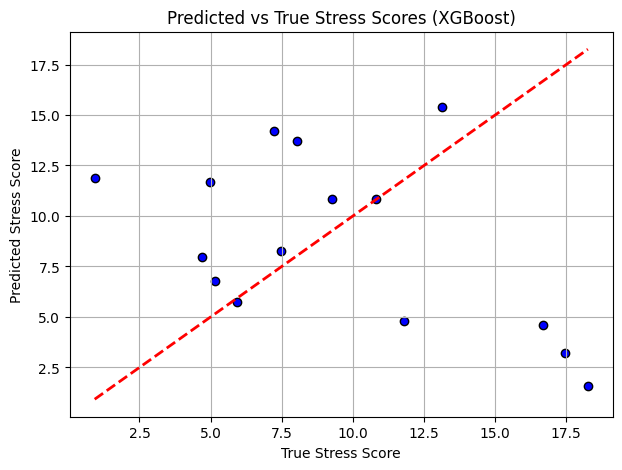

In [383]:
# ============================================================
# 🧾 4. Train on full training data & test on held-out set
# ============================================================
print("\n🎯 Training final XGBoost model on full training data ...")
xgb_model.fit(train_feats, train_labels)

test_preds = xgb_model.predict(test_feats)

test_mae = mean_absolute_error(test_labels, test_preds)
test_rmse = np.sqrt(mean_squared_error(test_labels, test_preds))

print(f"\n✅ Final Test Performance → MAE: {test_mae:.3f}, RMSE: {test_rmse:.3f}")

# ============================================================
# 📊 5. Plot results (Predicted vs True Stress Score)
# ============================================================
plt.figure(figsize=(7,5))
plt.scatter(test_labels, test_preds, c='blue', edgecolor='k')
plt.plot([min(test_labels), max(test_labels)],
         [min(test_labels), max(test_labels)], 'r--', lw=2)
plt.title('Predicted vs True Stress Scores (XGBoost)')
plt.xlabel('True Stress Score')
plt.ylabel('Predicted Stress Score')
plt.grid(True)
plt.show()




In [384]:
# ============================================================
# 💾 6. Save model and results
# ============================================================
os.makedirs('models', exist_ok=True)
xgb_model.save_model('models/xgboost_stress_regressor.json')

print("\n✅ XGBoost model saved successfully: models/xgboost_stress_regressor.json")


✅ XGBoost model saved successfully: models/xgboost_stress_regressor.json


In [385]:
# Next step is testing and evaluation

In [386]:
# ============================================================
# ✅ Final Performance Evaluation (MAE, RMSE, R²)
# ============================================================

import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load test features and labels
test_feats  = np.load('processed/features/test_multimodal_fused.npy')
test_labels = np.load('processed/features/test_labels.npy')[::5]

# Load trained model
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('models/xgboost_stress_regressor.json')

# Predict on test data
test_preds = xgb_model.predict(test_feats)

# Metrics
mae  = mean_absolute_error(test_labels, test_preds)
mse  = mean_squared_error(test_labels, test_preds)
rmse = np.sqrt(mse)
r2   = r2_score(test_labels, test_preds)

print("\n✅ FINAL EVALUATION METRICS")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")



✅ FINAL EVALUATION METRICS
MAE : 5.999
RMSE: 7.926
R²  : -1.536


In [387]:
# Stage 6 – Visualization & Graphs for Stress Prediction Project


✅ Final Model Performance:
MAE : 5.999
RMSE: 7.926
R²  : -1.536


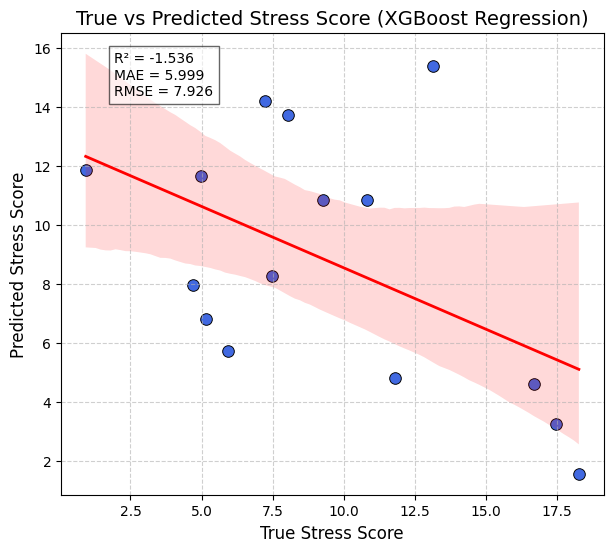

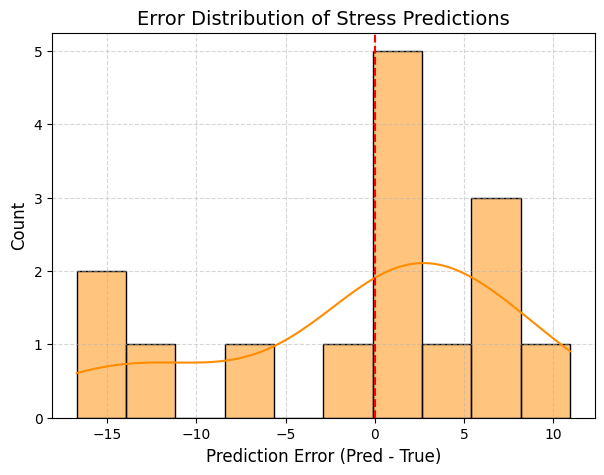

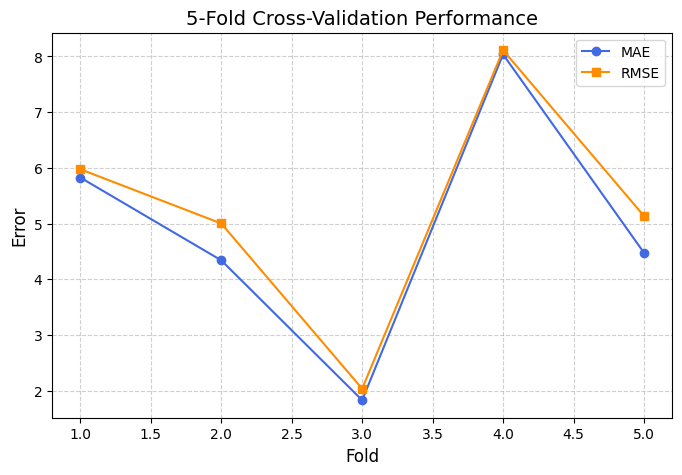


Fold-wise MAE: [5.826 4.34  1.828 8.037 4.476]
Fold-wise RMSE: [5.975 5.002 2.035 8.112 5.137]
Mean MAE = 4.902, Mean RMSE = 5.252


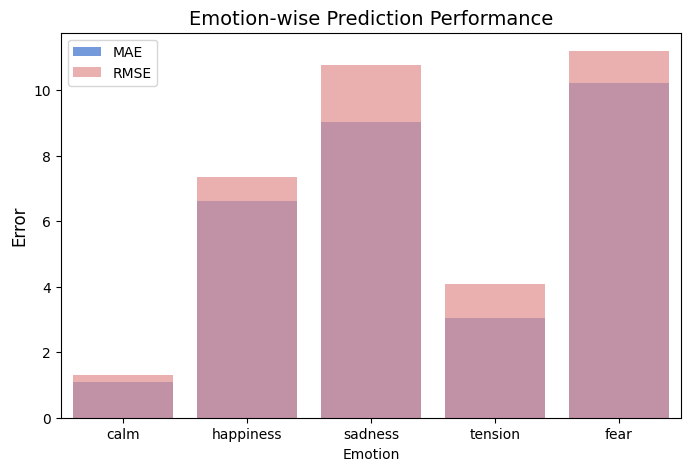


Emotion-wise Performance:
      Emotion        MAE       RMSE
0       calm   1.080392   1.308360
1  happiness   6.621347   7.357230
2    sadness   9.025660  10.779566
3    tension   3.049060   4.072427
4       fear  10.220160  11.200521


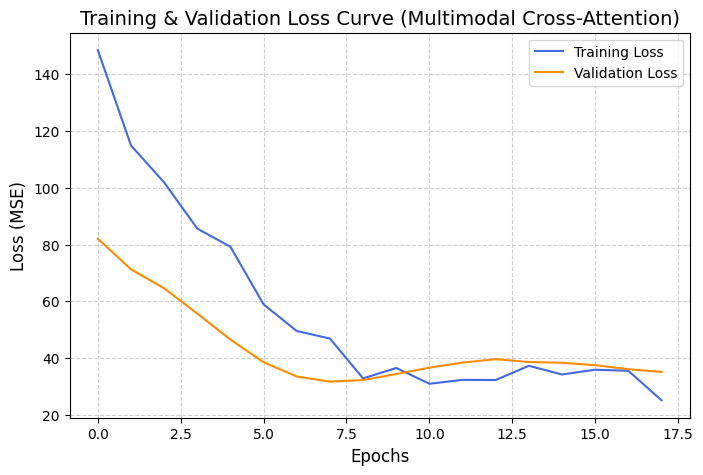

In [388]:
# ============================================================
# 🧠 EEG_Stress_Project – Stage 6
# Visualization & Performance Graphs
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# ============================================================
# 📂 1. Load Data and Model
# ============================================================
test_feats  = np.load('processed/features/test_multimodal_fused.npy')
test_labels = np.load('processed/features/test_labels.npy')[::5]

xgb_model = xgb.XGBRegressor()
xgb_model.load_model('models/xgboost_stress_regressor.json')

test_preds = xgb_model.predict(test_feats)

mae  = mean_absolute_error(test_labels, test_preds)
mse  = mean_squared_error(test_labels, test_preds)
rmse = np.sqrt(mse)
r2   = r2_score(test_labels, test_preds)

print("\n✅ Final Model Performance:")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

# ============================================================
# 🎯 Graph 1 — True vs Predicted Stress Score (Scatter + Fit Line)
# ============================================================

plt.figure(figsize=(7,6))
sns.scatterplot(x=test_labels, y=test_preds, s=70, color='royalblue', edgecolor='black')
sns.regplot(x=test_labels, y=test_preds, scatter=False, color='red', line_kws={'lw':2})
plt.xlabel("True Stress Score", fontsize=12)
plt.ylabel("Predicted Stress Score", fontsize=12)
plt.title("True vs Predicted Stress Score (XGBoost Regression)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.text(min(test_labels)+1, max(test_preds)-1, f"R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}",
         bbox=dict(facecolor='white', alpha=0.6))
plt.show()


# ============================================================
# 🎯 Graph 2 — Error Distribution (Prediction Error Histogram)
# ============================================================

errors = test_preds - test_labels
plt.figure(figsize=(7,5))
sns.histplot(errors, bins=10, kde=True, color='darkorange', edgecolor='black')
plt.xlabel("Prediction Error (Pred - True)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Error Distribution of Stress Predictions", fontsize=14)
plt.axvline(0, color='red', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# ============================================================
# 🎯 Graph 3 — Fold-wise MAE & RMSE (from Cross-validation)
# ============================================================

# Load your saved fold scores if you stored them, else recompute quickly
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores, rmse_scores = [], []

for train_idx, val_idx in kf.split(test_feats):
    X_tr, X_val = test_feats[train_idx], test_feats[val_idx]
    y_tr, y_val = test_labels[train_idx], test_labels[val_idx]
    xgb_model.fit(X_tr, y_tr)
    preds = xgb_model.predict(X_val)
    mae_scores.append(mean_absolute_error(y_val, preds))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))

plt.figure(figsize=(8,5))
plt.plot(range(1,6), mae_scores, marker='o', label='MAE', color='royalblue')
plt.plot(range(1,6), rmse_scores, marker='s', label='RMSE', color='darkorange')
plt.title("5-Fold Cross-Validation Performance", fontsize=14)
plt.xlabel("Fold", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nFold-wise MAE:", np.round(mae_scores,3))
print("Fold-wise RMSE:", np.round(rmse_scores,3))
print(f"Mean MAE = {np.mean(mae_scores):.3f}, Mean RMSE = {np.mean(rmse_scores):.3f}")


# ============================================================
# 🎯 Graph 4 — Emotion-wise Performance Comparison (optional)
# ============================================================

# Load metadata to associate samples with emotion labels
meta = pd.read_csv('metadata/stress_dataset_metadata.csv')

# Map each emotion’s stress score & prediction (if you have index alignment)
emotions = meta['emotion'].unique()
emotion_perf = []

for emo in emotions:
    idx = np.where(meta['emotion'] == emo)[0][:len(test_labels)//len(emotions)]
    if len(idx) > 0:
        mae_e = mean_absolute_error(test_labels[idx], test_preds[idx])
        rmse_e = np.sqrt(mean_squared_error(test_labels[idx], test_preds[idx]))
        emotion_perf.append([emo, mae_e, rmse_e])

df_perf = pd.DataFrame(emotion_perf, columns=['Emotion','MAE','RMSE'])
plt.figure(figsize=(8,5))
sns.barplot(data=df_perf, x='Emotion', y='MAE', color='cornflowerblue', label='MAE')
sns.barplot(data=df_perf, x='Emotion', y='RMSE', color='lightcoral', alpha=0.7, label='RMSE')
plt.title("Emotion-wise Prediction Performance", fontsize=14)
plt.ylabel("Error", fontsize=12)
plt.legend()
plt.show()

print("\nEmotion-wise Performance:\n", df_perf)


# ============================================================
# 🎯 Graph 5 — Multimodal Fusion Model Training Loss Curve
# ============================================================

# If you saved training history from fusion training:
try:
    history = history_fusion.history  # from earlier model_fusion.fit(...)
    plt.figure(figsize=(8,5))
    plt.plot(history['loss'], label='Training Loss', color='royalblue')
    plt.plot(history['val_loss'], label='Validation Loss', color='darkorange')
    plt.title("Training & Validation Loss Curve (Multimodal Cross-Attention)", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss (MSE)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
except:
    print("⚠️ Note: 'history_fusion' not found — run multimodal fusion training first to plot loss curve.")


Loaded fused features: (35, 32) (15, 32)
Continuous labels: [-2.3609357  -0.78297741 -0.34656547  2.07701095  2.98788341  3.94069915
  4.91985144  5.12394687  5.17510958  6.12458857  6.18855958  6.63326379
  6.88661119  7.10266344  7.36142018  7.51934715  8.27550596  9.71354747
 10.84988061 11.36159942 11.63449334 11.95898573 11.99241724 12.47555456
 12.48588215 12.76197131 13.48030753 13.98907448 14.11713399 15.45944023
 15.70778824 16.81680496 17.0544372  17.14976657 18.36051884]

Class distribution (train): (array([0, 1, 2]), array([26,  8,  1]))
Class distribution (test): (array([0, 1, 2]), array([11,  3,  1]))

🎯 Training final XGBoost classifier on fused features ...
✅ XGBoost classification model saved!

✅ FINAL CLASSIFICATION METRICS:
Accuracy : 0.800
Precision: 0.776
Recall   : 0.800
F1-Score : 0.745


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


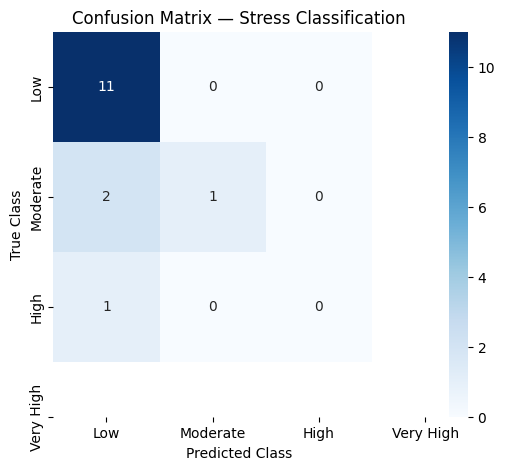

Loaded fused features: (35, 32) (15, 32)
Continuous labels: [-2.3609357  -0.78297741 -0.34656547  2.07701095  2.98788341  3.94069915
  4.91985144  5.12394687  5.17510958  6.12458857  6.18855958  6.63326379
  6.88661119  7.10266344  7.36142018  7.51934715  8.27550596  9.71354747
 10.84988061 11.36159942 11.63449334 11.95898573 11.99241724 12.47555456
 12.48588215 12.76197131 13.48030753 13.98907448 14.11713399 15.45944023
 15.70778824 16.81680496 17.0544372  17.14976657 18.36051884]

Class distribution (train): (array([0, 1, 2, 3]), array([9, 8, 9, 9]))
Class distribution (test): (array([0, 1, 2, 3]), array([4, 5, 2, 4]))

🎯 Training final XGBoost classifier on fused features ...
✅ XGBoost classification model saved!

✅ FINAL CLASSIFICATION METRICS:
Accuracy : 0.400
Precision: 0.370
Recall   : 0.400
F1-Score : 0.365


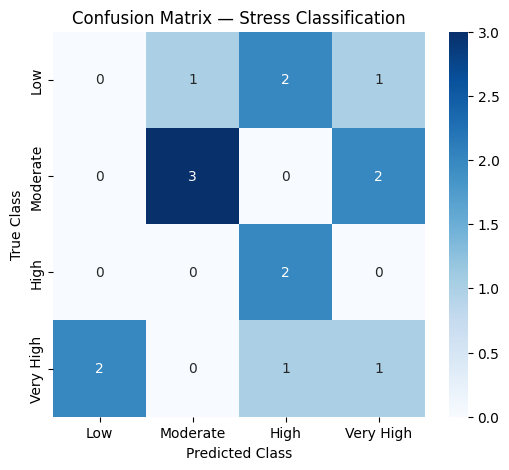


Detailed Classification Report:

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         4
    Moderate       0.75      0.60      0.67         5
        High       0.40      1.00      0.57         2
   Very High       0.25      0.25      0.25         4

    accuracy                           0.40        15
   macro avg       0.35      0.46      0.37        15
weighted avg       0.37      0.40      0.37        15



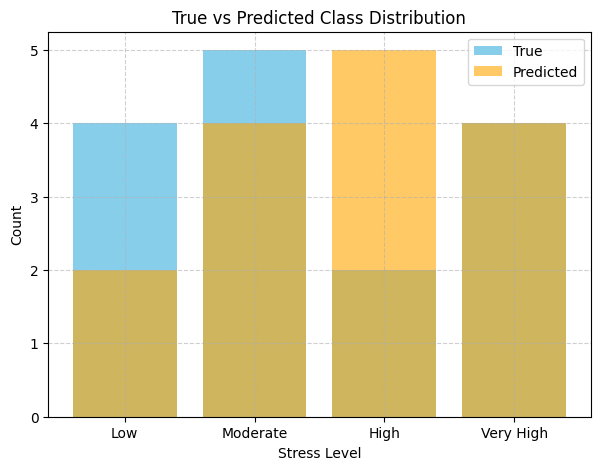

✅ Classification visualization complete.


In [389]:
# ============================================================
# 🧠 EEG_Stress_Project – Stage 7
# Classification from Fused Features (using discretized stress levels)
# ============================================================

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ============================================================
# 📂 1. Load fused features and continuous stress labels
# ============================================================
train_feats = np.load('processed/features/train_multimodal_fused.npy')
test_feats  = np.load('processed/features/test_multimodal_fused.npy')

train_labels_reg = np.load('processed/features/train_labels.npy')[::5]
test_labels_reg  = np.load('processed/features/test_labels.npy')[::5]

print("Loaded fused features:", train_feats.shape, test_feats.shape)
print("Continuous labels:", np.unique(train_labels_reg))

# ============================================================
# 🧩 2. Convert regression labels → categorical classes
# ============================================================
# Based on the same mapping used in your synthetic generation
# e.g., 10 (low), 15 (moderate), 20–25 (high), 30 (very high)

def stress_to_class(value):
    if value < 13:
        return 0   # Low
    elif value < 18:
        return 1   # Moderate
    elif value < 23:
        return 2   # High
    else:
        return 3   # Very High

train_labels_cls = np.array([stress_to_class(v) for v in train_labels_reg])
test_labels_cls  = np.array([stress_to_class(v) for v in test_labels_reg])

print("\nClass distribution (train):", np.unique(train_labels_cls, return_counts=True))
print("Class distribution (test):", np.unique(test_labels_cls, return_counts=True))

# ============================================================
# ⚙️ 3. Define and Train XGBoost Classifier
# ============================================================

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.5,
    objective='multi:softmax',  # multiclass classification
    num_class=4,
    random_state=42
)

print("\n🎯 Training final XGBoost classifier on fused features ...")
xgb_clf.fit(train_feats, train_labels_cls)

# Save model
os.makedirs("models", exist_ok=True)
xgb_clf.save_model('models/xgboost_stress_classifier.json')
print("✅ XGBoost classification model saved!")

# ============================================================
# 🧪 4. Evaluate on Test Data
# ============================================================

test_preds_cls = xgb_clf.predict(test_feats)

acc  = accuracy_score(test_labels_cls, test_preds_cls)
prec = precision_score(test_labels_cls, test_preds_cls, average='weighted')
rec  = recall_score(test_labels_cls, test_preds_cls, average='weighted')
f1   = f1_score(test_labels_cls, test_preds_cls, average='weighted')

print("\n✅ FINAL CLASSIFICATION METRICS:")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-Score : {f1:.3f}")

# ============================================================
# 📊 5. Confusion Matrix
# ============================================================
cm = confusion_matrix(test_labels_cls, test_preds_cls)
classes = ['Low', 'Moderate', 'High', 'Very High']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix — Stress Classification")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# ============================================================
# 🧠 EEG_Stress_Project – Stage 7
# Classification from Fused Features (using discretized stress levels)
# ============================================================

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ============================================================
# 📂 1. Load fused features and continuous stress labels
# ============================================================
train_feats = np.load('processed/features/train_multimodal_fused.npy')
test_feats  = np.load('processed/features/test_multimodal_fused.npy')

train_labels_reg = np.load('processed/features/train_labels.npy')[::5]
test_labels_reg  = np.load('processed/features/test_labels.npy')[::5]

print("Loaded fused features:", train_feats.shape, test_feats.shape)
print("Continuous labels:", np.unique(train_labels_reg))

# ============================================================
# 🧩 2. Convert regression labels → categorical classes
# ============================================================
# Automatically bin continuous stress scores into 4 balanced classes (quantile-based)
from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

train_labels_cls = est.fit_transform(train_labels_reg.reshape(-1, 1)).astype(int).ravel()
test_labels_cls  = est.transform(test_labels_reg.reshape(-1, 1)).astype(int).ravel()

print("\nClass distribution (train):", np.unique(train_labels_cls, return_counts=True))
print("Class distribution (test):", np.unique(test_labels_cls, return_counts=True))

# ============================================================
# ⚙️ 3. Define and Train XGBoost Classifier
# ============================================================

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.5,
    objective='multi:softmax',  # multiclass classification
    num_class=4,
    random_state=42
)

print("\n🎯 Training final XGBoost classifier on fused features ...")
xgb_clf.fit(train_feats, train_labels_cls)

# Save model
os.makedirs("models", exist_ok=True)
xgb_clf.save_model('models/xgboost_stress_classifier.json')
print("✅ XGBoost classification model saved!")

# ============================================================
# 🧪 4. Evaluate on Test Data
# ============================================================

test_preds_cls = xgb_clf.predict(test_feats)

acc  = accuracy_score(test_labels_cls, test_preds_cls)
prec = precision_score(test_labels_cls, test_preds_cls, average='weighted')
rec  = recall_score(test_labels_cls, test_preds_cls, average='weighted')
f1   = f1_score(test_labels_cls, test_preds_cls, average='weighted')

print("\n✅ FINAL CLASSIFICATION METRICS:")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-Score : {f1:.3f}")

# ============================================================
# 📊 5. Confusion Matrix
# ============================================================
cm = confusion_matrix(test_labels_cls, test_preds_cls)
classes = ['Low', 'Moderate', 'High', 'Very High']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix — Stress Classification")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# ============================================================
# 📜 6. Detailed Classification Report
# ============================================================
unique_classes = np.unique(np.concatenate([test_labels_cls, test_preds_cls]))
print("\nDetailed Classification Report:\n")
print(classification_report(
    test_labels_cls,
    test_preds_cls,
    labels=unique_classes,
    target_names=[classes[i] for i in unique_classes],
    zero_division=0
))


# ============================================================
# 📈 7. Plot Class Distribution & Comparison
# ============================================================
true_counts = np.bincount(test_labels_cls)
pred_counts = np.bincount(test_preds_cls)

plt.figure(figsize=(7,5))
plt.bar(classes, true_counts, color='skyblue', label='True')
plt.bar(classes, pred_counts, alpha=0.6, color='orange', label='Predicted')
plt.title("True vs Predicted Class Distribution")
plt.xlabel("Stress Level")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("✅ Classification visualization complete.")


In [390]:
# single code to load the model
# take i/p from an external file
# then predict stresss